In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mydata-csv/train.csv


In [2]:
import pandas as pd
from transformers import pipeline
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from math import exp
from tqdm import tqdm 

# Load Data
train_df_ = pd.read_csv("/kaggle/input/mydata-csv/train.csv")
train_df = train_df_.head(150)

# Select Pretrained Models
models = [
    "facebook/bart-large-cnn",
    "t5-large",
    "sshleifer/distilbart-cnn-12-6",
    "google/pegasus-large",
    "allenai/led-large-16384-arxiv",
]

# Initialize BLEU Scores list
bleu_scores = []

# Semantic Coherence (Example implementation)
def semantic_coherence(generated_summary, dialogue):
    # Your semantic coherence metric calculation logic
    summary_tokens = word_tokenize(generated_summary.lower())
    dialogue_tokens = word_tokenize(dialogue.lower())

    # Calculate the intersection of tokens
    common_tokens = set(summary_tokens) & set(dialogue_tokens)

    # Calculate semantic coherence score based on the ratio of common tokens to summary length
    coherence_score = len(common_tokens) / len(summary_tokens)

    return coherence_score

# Factual Accuracy (Example implementation)
def factual_accuracy(generated_summary, reference_summary):
    # Your factual accuracy metric calculation logic
    gen_tokens = set(word_tokenize(generated_summary.lower()))
    ref_tokens = set(word_tokenize(reference_summary.lower()))

    # Calculate the intersection of tokens
    common_tokens = gen_tokens & ref_tokens

    # Calculate factual accuracy score based on the ratio of common tokens to reference summary length
    accuracy_score = len(common_tokens) / len(ref_tokens) if len(ref_tokens) != 0 else 0
    return accuracy_score

# Content Coverage (Example implementation)
def content_coverage(generated_summary, dialogue):
    # Your content coverage metric calculation logic
    
    summary_tokens = set(word_tokenize(generated_summary.lower()))
    dialogue_tokens = set(word_tokenize(dialogue.lower()))

    # Calculate the intersection of tokens
    common_tokens = summary_tokens & dialogue_tokens

    # Calculate the content coverage score based on the ratio of common tokens to dialogue length
    coverage_score = len(common_tokens) / len(dialogue_tokens) if len(dialogue_tokens) != 0 else 0
    return coverage_score

# Initialize evaluation results DataFrame
evaluation_results = pd.DataFrame(columns=["Model", "BLEU Score", "Semantic Coherence", "Factual Accuracy", "Content Coverage"])

# Initialize empty list to store evaluation results
evaluation_results_list = []

# Apply Models and Evaluate
for model_name in models:
    print(f"Evaluating model: {model_name}")
    
    # Initialize the summarization pipeline
    summarizer = pipeline("summarization", model=model_name, tokenizer=model_name)
    
    # Initialize evaluation metric accumulators
    semantic_coherence_scores = []
    factual_accuracy_scores = []
    content_coverage_scores = []
    
    # Generate summaries
    generated_summaries = []
    for index, row in tqdm(train_df.iterrows(), total=len(train_df)):  # Use tqdm to show progress
        dialogue = row['dialogue']
        summary = row['summary']
        generated_summary = summarizer(dialogue, max_length=100, min_length=30, do_sample=False)[0]["summary_text"]
        generated_summaries.append(generated_summary)
        
        # Evaluate Semantic Coherence
        coherence_score = semantic_coherence(generated_summary, dialogue)
        semantic_coherence_scores.append(coherence_score)
        
        # Evaluate Factual Accuracy
        accuracy_score = factual_accuracy(generated_summary, summary)
        factual_accuracy_scores.append(accuracy_score)
        
        # Evaluate Content Coverage
        coverage_score = content_coverage(generated_summary, dialogue)
        content_coverage_scores.append(coverage_score)

    
    # Calculate BLEU Score
    reference_summaries = train_df["summary"].tolist()
    bleu_score = corpus_bleu([[summary] for summary in reference_summaries], generated_summaries)
    bleu_scores.append(bleu_score)
    
    # Append results to the evaluation results list
    evaluation_results_list.append({
        "Model": model_name,
        "BLEU Score": bleu_score,
        "Semantic Coherence": sum(semantic_coherence_scores) / len(semantic_coherence_scores),
        "Factual Accuracy": sum(factual_accuracy_scores) / len(factual_accuracy_scores),
        "Content Coverage": sum(content_coverage_scores) / len(content_coverage_scores),
    })
    
    # Print a separator for clarity
    print("="*50)

# Concatenate the evaluation results list into a DataFrame
evaluation_results = pd.concat([pd.DataFrame(item, index=[0]) for item in evaluation_results_list], ignore_index=True)

# Compare Results
print("BLEU Scores:", bleu_scores)

# Save evaluation results to a CSV file
evaluation_results.to_csv("evaluation_results.csv", index=False)


Evaluating model: facebook/bart-large-cnn


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

100%|██████████| 150/150 [21:21<00:00,  8.54s/it]


Evaluating model: t5-large


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
100%|██████████| 150/150 [46:40<00:00, 18.67s/it]


Evaluating model: sshleifer/distilbart-cnn-12-6


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

100%|██████████| 150/150 [16:25<00:00,  6.57s/it]


Evaluating model: google/pegasus-large


config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

100%|██████████| 150/150 [49:02<00:00, 19.62s/it]


Evaluating model: allenai/led-large-16384-arxiv


config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

100%|██████████| 150/150 [55:34<00:00, 22.23s/it]


BLEU Scores: [0.3488121983156154, 0.3397876196809291, 0.30525945503925905, 0.36171531600300605, 0.15297269719096934]


In [3]:
evaluation_results.head()

,Model,BLEU Score,Semantic Coherence,Factual Accuracy,Content Coverage
0,facebook/bart-large-cnn,0.348812,0.655736,0.458349,0.371619
1,t5-large,0.339788,0.755254,0.457265,0.408908
2,sshleifer/distilbart-cnn-12-6,0.305259,0.708327,0.521721,0.483919
3,google/pegasus-large,0.361715,0.707104,0.420562,0.363004
4,allenai/led-large-16384-arxiv,0.152973,0.243868,0.284099,0.186362


In [4]:
topsis_df = pd.read_csv("/kaggle/input/topsis/topsis.csv")
topsis_df

,Model,BLEU Score,Semantic Coherence,Factual Accuracy,Content Coverage,Topsis Score,Rank
0,facebook/bart-large-cnn,0.348812,0.655736,0.458349,0.371619,0.711052,3.0
1,t5-large,0.339788,0.755254,0.457265,0.408908,0.811418,2.0
2,sshleifer/distilbart-cnn-12-6,0.305259,0.708327,0.521721,0.483919,0.942741,1.0
3,google/pegasus-large,0.361715,0.707104,0.420562,0.363004,0.694085,4.0
4,allenai/led-large-16384-arxiv,0.152973,0.243868,0.284099,0.186362,0.000000,5.0


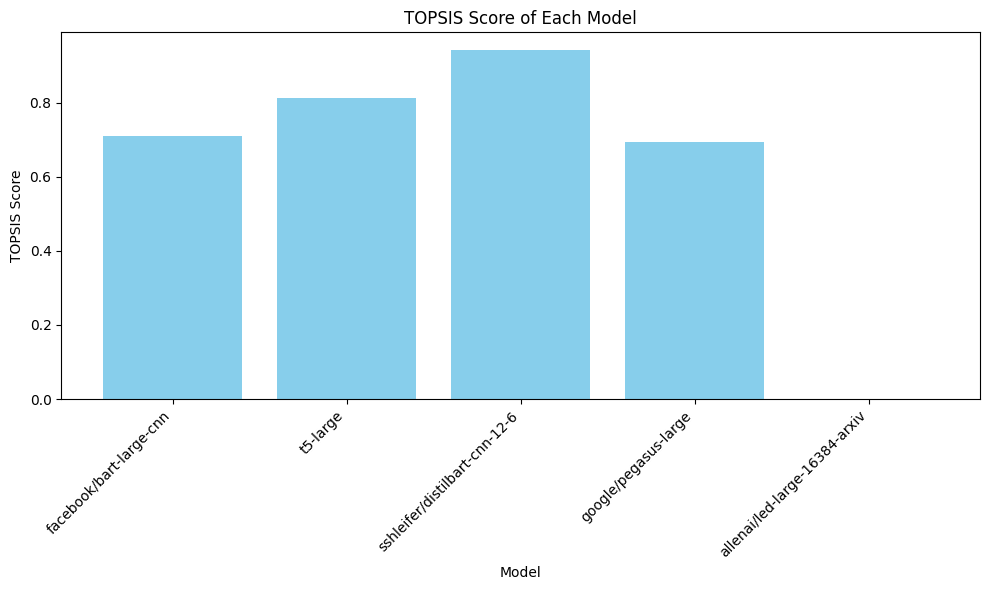

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(topsis_df["Model"], topsis_df["Topsis Score"], color='skyblue')
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Score of Each Model")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()